In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

file_ = "/content/sample_data/Maternal Health Risk Data Set.csv"
df = pd.read_csv(file_)

class_mapping = {'high risk':2, 'mid risk':1, 'low risk':0}
df['RiskLevel'] = df['RiskLevel'].map(class_mapping)
df


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,2
1010,55,120,90,18.0,98.0,60,2
1011,35,85,60,19.0,98.0,86,2
1012,43,120,90,18.0,98.0,70,2


In [ ]:
# Split training/test data

X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

In [ ]:
# Feature Importance and Subset Selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

feat_labels = df.columns[:-1]
forest = RandomForestClassifier(criterion = 'gini', n_estimators = 100, random_state = 1, n_jobs = -1)
X, y = df.iloc[:, :-1].values, df.iloc[:,6].values

forest.fit(X,y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
  print('%2d)%-*s%f'%(f+1,30,feat_labels[indices[f]],importances[indices[f]]))

sfm = SelectFromModel(forest, threshold = 0.13, prefit = True)
X_selected = sfm.transform(X_train)
X_testselected = sfm.transform(X_test)

 1)BS                            0.359473
 2)SystolicBP                    0.186159
 3)Age                           0.159966
 4)DiastolicBP                   0.125345
 5)HeartRate                     0.103199
 6)BodyTemp                      0.065858


In [ ]:
# Using Ordinal Regression
from statsmodels.miscmodels.ordinal_model import OrderedModel
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OrdinalEncoder
df_1 = pd.read_csv(file_)

X_ord = df_1[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']]
y_ord = df_1['RiskLevel']


X_train_ord, X_test_ord, y_train_ord, y_test_ord =\
    train_test_split(X_ord, y_ord, test_size = 0.2, random_state = 1, stratify = y)

y_type = CategoricalDtype(categories=['low risk', 'mid risk', 'high risk'], ordered=True)
y_traindf = y_train_ord.astype(y_type)
y_testdf = y_test_ord.astype(y_type)

mod_prob = OrderedModel(y_traindf,X_train_ord, distr='probit')
res_prob = mod_prob.fit(method='bfgs')

print(res_prob.summary())

# Thresholds for different categories
num_of_thresholds = 2
print("Thresholds for different categories:", mod_prob.transform_threshold_params(res_prob.params[-num_of_thresholds:]))
print('')

# Test Data Prediction via Ordinal Regression
predicted = res_prob.model.predict(res_prob.params, exog=X_test_ord)
pred_choice = predicted.argmax(1)
print("Fraction of correct choice predictions")
print((np.asarray(y_testdf.values.codes) == pred_choice).mean())

# Systolic BP, HeartRate, BS, and Body Temp are statistically significant

Optimization terminated successfully.
         Current function value: 0.798629
         Iterations: 33
         Function evaluations: 37
         Gradient evaluations: 37
                             OrderedModel Results                             
Dep. Variable:              RiskLevel   Log-Likelihood:                -647.69
Model:                   OrderedModel   AIC:                             1311.
Method:            Maximum Likelihood   BIC:                             1349.
Date:                Thu, 18 Jul 2024                                         
Time:                        23:27:56                                         
No. Observations:                 811                                         
Df Residuals:                     803                                         
Df Model:                           6                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

In [ ]:
# Build pipelines and check CV accuracy

# Random Forest
pipe_rf = make_pipeline(StandardScaler(),
  RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=-1))

scores_rf = cross_val_score(estimator = pipe_rf,
  X = X_selected, y = y_train, cv = 10, n_jobs = -1)

print('Random Forest CV accuracy scores: {}'.format(scores_rf))
print('Random Forest CV accuracy mean:{} and std:{}'.format(np.mean(scores_rf), np.std(scores_rf)))
print('')

# Logistic Regression
pipe_lr = make_pipeline(StandardScaler(),
  LogisticRegression(max_iter=10000, n_jobs=-1, random_state=1, multi_class = 'multinomial'))

scores_lr = cross_val_score(estimator = pipe_lr,
  X = X_selected,y = y_train, cv = 10, n_jobs = -1)

print('Logistic Regression CV accuracy scores: {}'.format(scores_lr))
print('Logistic Regression CV accuracy mean:{} and std:{}'.format(np.mean(scores_lr), np.std(scores_lr)))
print('')

#SVM
pipe_svm = make_pipeline(StandardScaler(),
  SVC(C= 0.5, kernel='rbf', random_state=1))

scores_svm = cross_val_score(estimator = pipe_svm,
  X = X_selected, y = y_train, cv = 10, n_jobs = -1)

print('SVM CV accuracy scores: {}'.format(scores_svm))
print('SVM CV accuracy mean:{} and std:{}'.format(np.mean(scores_svm), np.std(scores_svm)))
print('')

#K-Nearest Neighbors
pipe_knn = make_pipeline(StandardScaler(),
  KNeighborsClassifier(n_neighbors=5))

scores_knn = cross_val_score(estimator = pipe_knn,
  X = X_selected, y = y_train, cv = 10, n_jobs = -1)

print('KNN CV accuracy scores: {}'.format(scores_knn))
print('KNN CV accuracy mean:{} and std:{}'.format(np.mean(scores_knn), np.std(scores_knn)))
print('')

#Decision Tree
pipe_dt = make_pipeline(StandardScaler(),
  DecisionTreeClassifier(criterion = 'gini', random_state=1))

scores_dt = cross_val_score(estimator = pipe_dt,
  X = X_selected, y = y_train, cv = 10, n_jobs = -1)

print('Decision Tree CV accuracy scores: {}'.format(scores_knn))
print('Decision Tree CV accuracy mean:{} and std:{}'.format(np.mean(scores_knn), np.std(scores_knn)))
print('')

Random Forest CV accuracy scores: [0.84146341 0.87654321 0.81481481 0.79012346 0.85185185 0.86419753
 0.77777778 0.85185185 0.72839506 0.83950617]
Random Forest CV accuracy mean:0.8236525143029206 and std:0.04356727250401872

Logistic Regression CV accuracy scores: [0.48780488 0.5308642  0.44444444 0.55555556 0.59259259 0.45679012
 0.56790123 0.62962963 0.55555556 0.56790123]
Logistic Regression CV accuracy mean:0.5389039445950015 and std:0.05629466024489502

SVM CV accuracy scores: [0.67073171 0.65432099 0.66666667 0.61728395 0.62962963 0.66666667
 0.64197531 0.67901235 0.56790123 0.64197531]
SVM CV accuracy mean:0.6436163806082505 and std:0.03129301985915184

KNN CV accuracy scores: [0.7195122  0.79012346 0.75308642 0.62962963 0.7654321  0.75308642
 0.65432099 0.77777778 0.64197531 0.71604938]
KNN CV accuracy mean:0.7200993676603432 and std:0.05576128073836026

Decision Tree CV accuracy scores: [0.7195122  0.79012346 0.75308642 0.62962963 0.7654321  0.75308642
 0.65432099 0.77777778 

In [ ]:
# Tune the Random Forest hyperparameters for most accurate algorithm

from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 300],
              'criterion': ['gini', 'entropy'],
              'max_depth': [None, 1, 2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4, 5],
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]}


forest = RandomForestClassifier(criterion='gini', n_estimators=100, random_state=1, n_jobs=-1)

grids = GridSearchCV(estimator=forest, param_grid=param_grid, cv=10, refit=True, n_jobs=-1)
gs = grids.fit(X_selected, y_train)

print(gs.best_score_)
print(gs.best_params_)
print('')


0.827371273712737
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}



In [ ]:
# Optimized Random Forest Model
from sklearn.metrics import f1_score

pipe_rf_1 = make_pipeline(StandardScaler(),
  RandomForestClassifier(criterion='gini', min_samples_split=3, n_estimators=100, random_state=1, n_jobs=-1))

scores_optimizedrf = cross_val_score(estimator = pipe_rf_1,
  X = X_selected, y = y_train, cv = 10, n_jobs = -1)

print('Optimized Random Forest CV accuracy scores: {}'.format(scores_optimizedrf))
print('Optimized Random Forest CV accuracy mean:{} and std:{}'.format(np.mean(scores_optimizedrf), np.std(scores_optimizedrf)))
print ('')

#Calculating accuracy of algorithm on test data
pipe_rf_1.fit(X_selected, y_train)
y_pred = pipe_rf_1.predict(X_testselected)
print ('Test Accuracy:%.3f'% pipe_rf_1.score(X_testselected,y_test))
print ('F1:%.3f'% f1_score(y_true=y_test, y_pred=y_pred, average = 'weighted'))


Optimized Random Forest CV accuracy scores: [0.82926829 0.88888889 0.81481481 0.79012346 0.87654321 0.82716049
 0.77777778 0.88888889 0.74074074 0.85185185]
Optimized Random Forest CV accuracy mean:0.8286058416139715 and std:0.04699344858995719

Test Accuracy:0.813
F1:0.812


[[69 11  1]
 [14 48  5]
 [ 1  6 48]]


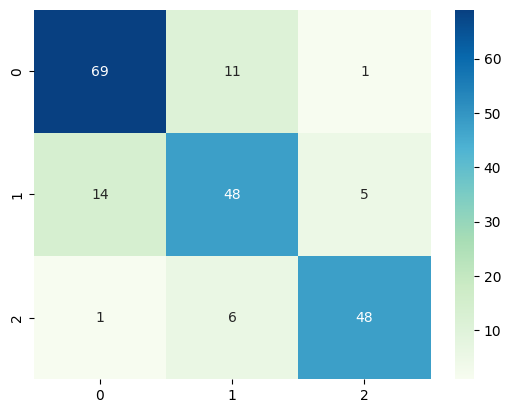

In [ ]:
# 3x3 confusion matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = pipe_rf_1.predict(X_testselected)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True,cmap='GnBu')
